
# Analysis of the 1D XXZ Heisenberg Spin Chain

This notebook explores the ground state properties of the 1D spin-1/2 XXZ Heisenberg model using exact diagonalization techniques. The model captures rich quantum behavior, including quantum phase transitions, and serves as a benchmark system in the study of strongly correlated quantum systems.

We'll proceed step by step, constructing the Hamiltonian, computing observables, and studying the scaling behavior of physical quantities like the energy gap and local magnetization.
    


## 1. The XXZ Model

We consider the Hamiltonian of the spin-1/2 XXZ chain with open boundary conditions:

$$
H = \sum_{i=0}^{L-2} \left[ \frac{J_{xy}}{2}(S^+_i S^-_{i+1} + S^-_i S^+_{i+1}) + J_{zz} S^z_i S^z_{i+1} \right] + \sum_{i=0}^{L-1} h_z S^z_i
$$

- $J_{xy}$ controls the flip-flop (XY) interaction.
- $J_{zz}$ represents the Ising-type interaction along the $z$ direction.
- $h_z$ is a uniform magnetic field applied along the $z$ axis.
- The spin operators $S^z_i$, $S^+_i$, $S^-_i$ act on site $i$.
- $L$ is the length of the spin chain.

The model conserves total $S^z_{	ext{tot}}$, which allows us to work within fixed magnetization sectors.
    

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
    

️ 2. Building the XXZ Hamiltonian

In [2]:

def build_xxz_hamiltonian(L, Jzz=1.0, Jxy=1.0, hz=0.0, m=0):
    Nup = L // 2 + m
    basis = spin_basis_1d(L, Nup=Nup)
    J_zz = [[Jzz, i, i + 1] for i in range(L - 1)]
    J_xy = [[Jxy / 2.0, i, i + 1] for i in range(L - 1)]
    h_z = [[hz, i] for i in range(L)]
    static = [["+-", J_xy], ["-+", J_xy], ["zz", J_zz], ["z", h_z]]
    H = hamiltonian(static, [], basis=basis, dtype=np.float64)
    return H, basis
    

Let's test the Hamiltonian construction

In [3]:

L = 4
H, basis = build_xxz_hamiltonian(L, Jzz=1.0, hz=0.1, m=0)
print("Hilbert space dimension:", basis.Ns)
print("Hamiltonian shape:", H.shape)
H
    

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hilbert space dimension: 6
Hamiltonian shape: (6, 6)


<quspin.operators.hamiltonian:
static mat: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 18 stored elements and shape (6, 6)>
dynamic:>


## 3. Ground State Energy and the Spin Gap

To analyze quantum phase transitions, we examine the energy difference between the lowest states in two magnetization sectors:

$$
\Delta = E_{m=1} - E_{m=0}
$$

This is known as the **spin gap**. It serves as a key quantity:

- If $\Delta 	o 0$ as $L 	o \infty$, the system is in a **gapless phase**.
- If $\Delta > 0$ in the thermodynamic limit, the system is in a **gapped phase**.

The 1D XXZ chain exhibits a well-known transition:
- For $J_{zz} < 1$, the system is gapless (critical XY phase).
- For $J_{zz} > 1$, the system enters a gapped antiferromagnetic phase.
- The critical point is at $J_{zz} = 1$.

We compute this gap by evaluating the ground state energy in the $m=0$ and $m=1$ sectors as a function of chain length $L$.
    

In [4]:

def energy_sweep(Jzz=1.0, Jxy=1.0, hz=0.0, m=0, maxsize=16):
    energies = []
    for L in range(4, maxsize+1, 4):
        H, _ = build_xxz_hamiltonian(L, Jzz=Jzz, Jxy=Jxy, hz=hz, m=m)
        E0 = H.eigsh(k=1, which="SA", return_eigenvectors=False)[0]
        energies.append(E0)
    return np.array(energies)
    

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


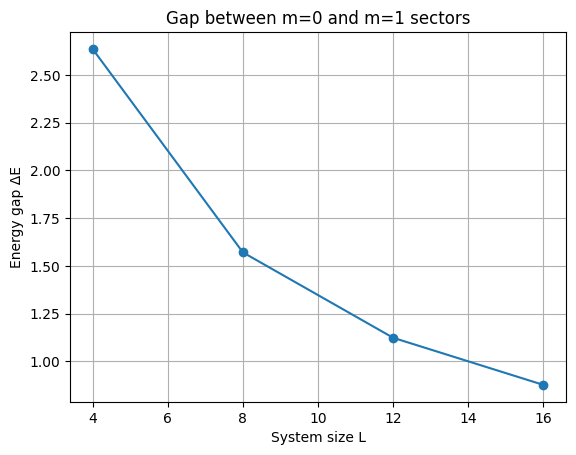

In [5]:

Lmax = 16
gap = energy_sweep(m=1, maxsize=Lmax) - energy_sweep(m=0, maxsize=Lmax)
Ls = np.arange(4, Lmax+1, 4)

plt.plot(Ls, gap, 'o-')
plt.xlabel("System size L")
plt.ylabel("Energy gap ΔE")
plt.title("Gap between m=0 and m=1 sectors")
plt.grid(True)
plt.show()
    

In [6]:

def fit_gap_to_thermodynamic_limit(gap, Ls, show_plot=True):
    x = 1.0 / Ls
    coeffs = np.polyfit(x, gap, 2)
    p = np.poly1d(coeffs)
    if show_plot:
        xs = np.linspace(0, x.max(), 200)
        plt.figure()
        plt.scatter(x, gap, s=60, edgecolor="k", label="Gap data")
        plt.plot(xs, p(xs), "-", linewidth=2, label="Quadratic fit")
        plt.xlabel(r"$1/L$")
        plt.ylabel(r"$\Delta E$")
        plt.title("Gap Extrapolation to Thermodynamic Limit")
        plt.grid(True)
        plt.legend()
        plt.show()
    return coeffs[2]
    

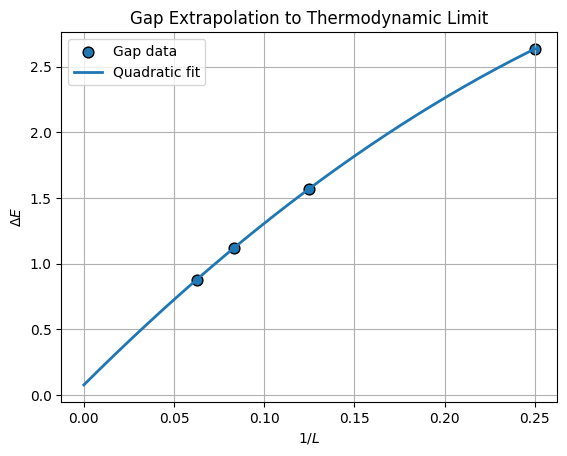

Estimated gap in thermodynamic limit: 0.07750698857403382


In [7]:

tl_gap = fit_gap_to_thermodynamic_limit(gap, Ls)
print("Estimated gap in thermodynamic limit:", tl_gap)
    

5. Local Magnetization ⟨Sᶻᵢ⟩


## 5. Local Magnetization Profile $\langle S^z_i \rangle$

Once we obtain the ground state of the system, we can compute the expectation value of the local spin operator $S^z_i$ at each site.

This observable provides insight into:
- Edge effects or boundary-induced polarization
- Broken symmetry in the antiferromagnetic phase
- Uniform magnetization profiles in external fields

The expectation value is computed as:

$$
\langle S^z_i \rangle = \langle \psi_0 | S^z_i | \psi_0 \rangle
$$

where $|\psi_0\rangle$ is the ground state of the Hamiltonian. To ensure a unique and stable ground state (especially for $m=0$), we include a small uniform field $h_z$.
    

In [8]:
def sz_expectation_per_site(L=12, Jzz=1.0, Jxy=1.0, hz=0.0, m=0):
    """
    Computes the expectation value ⟨S^z_i⟩ for each site i in the ground state
    of the 1D spin-1/2 XXZ Heisenberg chain with open boundary conditions.

    Parameters:
        L (int): Chain length.
        Jzz (float): Coupling strength along z.
        Jxy (float): XY (flip-flop) coupling strength.
        hz (float): Uniform magnetic field along z (with slight site-dependent variation).
        m (int): Magnetization sector (S^z_total = m).

    Returns:
        np.ndarray: Array of expectation values ⟨S^z_i⟩ for i = 0, ..., L-1.
    """
    # Define basis with fixed magnetization
    Nup = L // 2 + m
    basis = spin_basis_1d(L, Nup=Nup)

    # Coupling lists
    J_zz = [[Jzz, i, i+1] for i in range(L-1)]
    J_xy = [[Jxy / 2.0, i, i+1] for i in range(L-1)]
    h_z  = [[hz + 1e-3 * i, i] for i in range(L)]  # small perturbation to lift degeneracy

    # Define Hamiltonian
    static = [["+-", J_xy], ["-+", J_xy], ["zz", J_zz], ["z", h_z]]
    H = hamiltonian(static, [], basis=basis, dtype=np.float64)

    # Ground state calculation
    _, psi0 = H.eigsh(k=1, which="SA")
    psi0 = psi0[:, 0]

    # Expectation values ⟨S^z_i⟩
    sz_vals = np.array([
        np.vdot(psi0, hamiltonian([["z", [[1.0, i]]]], [], basis=basis).dot(psi0)).real
        for i in range(L)
    ])

    return sz_vals

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Part

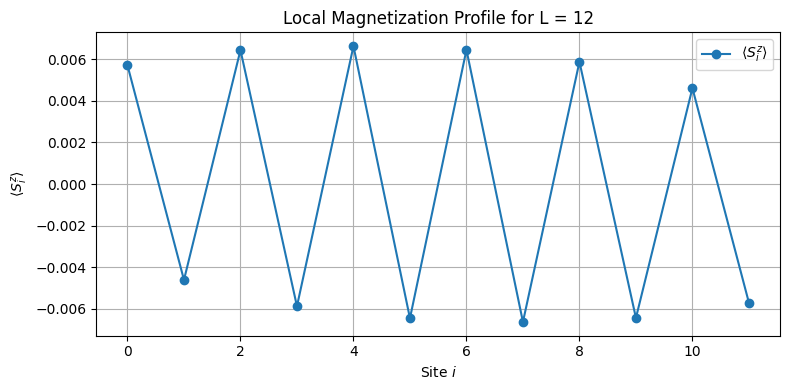

In [9]:
L = 12
sz_vals = sz_expectation_per_site(L=L, Jzz=1.5, hz=0.1, m=0)

plt.figure(figsize=(8, 4))
plt.plot(range(L), sz_vals, 'o-', label=r'$\langle S^z_i \rangle$')
plt.xlabel("Site $i$")
plt.ylabel(r"$\langle S^z_i \rangle$")
plt.title(f"Local Magnetization Profile for L = {L}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we systematically analyzed the 1D XXZ Heisenberg spin chain.

Key steps included:
- Defining and constructing the Hamiltonian using symmetry sectors
- Calculating ground state energies in $m=0$ and $m=1$ magnetization sectors
- Extracting the spin gap and extrapolating it to the thermodynamic limit
- Computing site-resolved local magnetization $\langle S^z_i \rangle$

These techniques provide a foundation for studying quantum phase transitions and low-energy physics in one-dimensional systems.
    